## Data Preparation

### Imports

Packages that need to be imported:

In [1]:
import pandas as pd
import json
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

### Read dataframe

Read json file with words and the list of videos:

In [2]:
url = "https://raw.githubusercontent.com/dxli94/WLASL/master/start_kit/WLASL_v0.3.json"
df = pd.read_json(url)
df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [3]:
#Export a list of words in csv
#df["gloss"].to_csv("list_words.csv")

### Filter df only selected words

Filter the json file with words that will be used to train our model. This file will be used later to download the videos.

In [3]:
list_selected_words = ["headache", "cough", "sore throat", "blood", "pregnant", "diabetes", 
                       "stomach","pain", "allergy", "cold", "bone","diarrhea", "heart", "heart attack", 
                       "cochlear implant", "vomit", "depressed", "hurt", "infection", "tired", "thank you"]

df = df[df['gloss'].isin(list_selected_words)]
df.head()

,gloss,instances
117,headache,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
147,cold,"[{'bbox': [129, 16, 476, 370], 'fps': 25, 'fra..."
175,tired,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
269,cough,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
287,heart,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [4]:
print(f"Df shape: {df.shape}")

Df shape: (21, 2)


### Export pandas df to json file

In [6]:
#new_json = df.to_json("WLASL_v0.3.json", orient='records')

### Explore instances

Create a dataframe with video_ids and the corresponding word. Notice that in this step we are using the json file exported in the previous step, which contains information about only 21 words.

In [5]:
content = json.load(open("../scripts/WLASL_v0.3.json"))

id_videos = []
for entry in content:
    word = entry["gloss"]
    instances = entry['instances']

    for inst in instances:
        video_id = inst['video_id']
        id_videos.append([word, video_id])

In [6]:
id_list = pd.DataFrame(id_videos, columns=["word", "video_id"])
id_list.head()

,word,video_id
0,headache,26832
1,headache,26835
2,headache,26836
3,headache,26837
4,headache,26838


Because of problems during download, we were not able to download all video_ids. To count the real number of videos that we have available, we need to check if they are in our folder.

In [7]:
ids_in_folder = []

for video_id in id_list.video_id:
    if os.path.exists(f'../raw_data/{video_id}.mp4'):
        ids_in_folder.append(video_id)

print(f"Number os videos: {len(ids_in_folder)}")

Number os videos: 154


Filter dataframe to only videos available in our folder:

In [8]:
id_list = id_list[id_list['video_id'].isin(ids_in_folder)]
print(f"Shape new df: {id_list.shape}")

Shape new df: (154, 2)


#### Count videos per symptoms
Check how many videos we have, by symptom, to train our model.

In [9]:
aux_list = id_list.groupby("word").count().reset_index()
aux_list.sort_values("video_id")

,word,video_id
2,bone,4
1,blood,5
14,pain,6
18,thank you,6
13,infection,6
6,depressed,6
7,diabetes,6
15,pregnant,6
11,heart attack,6
0,allergy,7


## Setup Preparation

### Setup Folder

In [12]:
# # Path for exported data, numpy arrays
# DATA_PATH = os.path.join('../MP_Data') 

# # Videos are going to be 70 frames in length
# sequence_length = 70 #wont be used anymore

In [13]:
# # ----------------------------------------------------
# # Loop to create folders for each action to be trained
# # and n_folder depending on the number of videos
# # ----------------------------------------------------

# for word in range(0, len(aux_list.word)):   # modificar range depois dos testes (0, len..)
    
#     # Identify how many videos per action
#     n_folders = aux_list.iloc[word, 1]
    
#     # Create folders
#     for n in range(n_folders):
#         try:
#             folder = os.path.join(DATA_PATH, aux_list.iloc[word, 0], str(n))
#             os.makedirs(folder)
#         except:
#             pass

### Functions for data detection

In [10]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [11]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [14]:
mediapipe_detection

<function __main__.mediapipe_detection(image, model)>

In [15]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [16]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [17]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

## Length Histogram

### To check lenght of videos

In [18]:
# Function to extract video id for selected word - Giovanna 
def videos_word(word):
  
    id_list_novo = id_list[id_list['word'] == word]
    lista_videos = [video_id for video_id in id_list_novo.video_id]
    
    return lista_videos

In [21]:
# Function to return duration and framecount for each video
def with_opencv(filename):
    import cv2
    video = cv2.VideoCapture(filename)

    duration = video.get(cv2.CAP_PROP_POS_MSEC)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

    return duration, frame_count



# Get id_videos from function video_words and return lenght
n_frames = []
teste = []

for word in aux_list["word"]:
    for video_id in videos_word(word):
        video = f'../raw_data/{video_id}.mp4'
        frame_count = with_opencv(video)[1]
        n_frames.append(frame_count)
        teste.append([word, video_id, frame_count])
        
frames_words = pd.DataFrame(teste, columns=["action", "video_id", "frames"])
frames_words

,action,video_id,frames
0,allergy,01962,54.0
1,allergy,01955,119.0
2,allergy,01965,106.0
3,allergy,01956,40.0
4,allergy,01957,108.0
...,...,...,...
149,vomit,61987,30.0
150,vomit,61990,98.0
151,vomit,61978,115.0
152,vomit,61979,84.0


NameError: name 'n_frames' is not defined

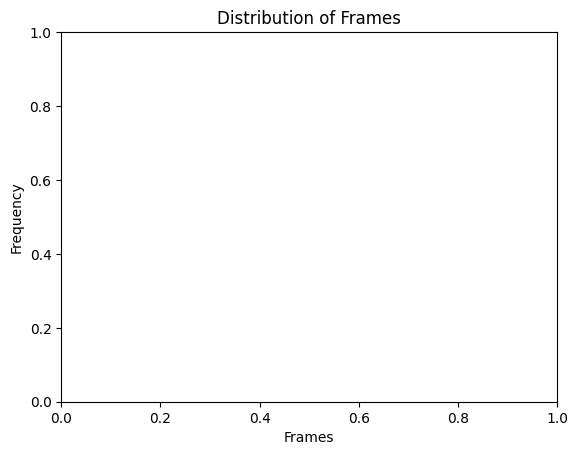

In [19]:
# Plot distribution frames 
plt.title("Distribution of Frames")
plt.xlabel('Frames')
plt.ylabel('Frequency')
plt.hist(pd.DataFrame(n_frames), bins=30, color="g", stacked=True);
plt.text(80, 15, f'Optimal number \n of frames=70');

In [23]:
# Function to retrieve words, video, frames

def words_video(word):
    w = frames_words[frames_words['action'] == word].reset_index()
    return w


In [24]:
words_video("cochlear implant")

,index,action,video_id,frames
0,16,cochlear implant,65373,57.0
1,17,cochlear implant,11498,98.0
2,18,cochlear implant,11499,33.0
3,19,cochlear implant,11500,32.0
4,20,cochlear implant,11501,128.0
5,21,cochlear implant,11502,65.0
6,22,cochlear implant,11503,33.0
7,23,cochlear implant,11504,50.0


## Data Points - New

#### Model Plan A - with loop

In [20]:
# ---------------------------------------------------
# Function to extract data points
# Action = word
# Folder = /word/number_folder
# Video_id = name of the video
# ---------------------------------------------------


def extract_datapoints(action, folder, video_id, frames):
    
    data_path = os.path.join('../MP_Data')
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        for frame_num in range(frames):

                    # Read feed
                    ret, frame = cap.read()

                    # Make detections
                    try:
                        image, results = mediapipe_detection(frame, holistic)
                        print(results)

                        # Draw landmarks and text
                        draw_styled_landmarks(image, results)
                        cv2.putText(image, 'Frames for {} video {}'.format(action, folder), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 0, 255), 1, cv2.LINE_AA)

                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(500)

                        # Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(data_path, action, folder, str(frame_num))
                        np.save(npy_path, keypoints)

                        # Break gracefully
                        if cv2.waitKey(10) & 0xFF == ord('q'):
                            break
                    except:
                        pass

In [28]:
# # ---------------------------------------------------
# # Loop to extract data points using function
# # ---------------------------------------------------

# selected_word = ["pregnant"]

# for word in selected_word:
            
#     # Filter the dataframe
#     df_temp = frames_words[frames_words["action"] == word] 

#     # Get information for each action
#     for word in range(0, len(df_temp.action)):

#         action = df_temp.iloc[word, 0]
#         cap = cv2.VideoCapture(f"../raw_data/{df_temp.iloc[word, 1]}.mp4")
#         sequence_folder = word
#         frames = [int(df_temp.iloc[word, 2]) if int(df_temp.iloc[word, 2]) < 70 else 70][0]

#         # Call the function to extract data points
#         extract_datapoints(action, str(sequence_folder), cap, frames)

#### Model  - Plan B 

### Np array comparison

In [21]:
# Sem loop
for i in range(0, 25):
    print(np.load(f"../MP_Data/stomach/4/{i}.npy"))

[ 0.57193285  0.22017854 -1.21904743 ...  0.56454998  0.98780501
 -0.04535049]
[ 0.57182086  0.22017053 -1.21666038 ...  0.56297451  0.98693269
 -0.04896437]
[ 0.56920975  0.22020189 -1.22161901 ...  0.56155217  0.98782045
 -0.05091175]
[ 0.56656766  0.22038238 -1.24134922 ...  0.56062192  0.9881565
 -0.04992827]
[ 0.56610423  0.22070996 -1.25370991 ...  0.56032741  0.98862565
 -0.04985459]
[ 0.56602693  0.22074513 -1.27188563 ...  0.56094748  0.98994315
 -0.04982345]
[ 0.56592685  0.22074993 -1.27112269 ...  0.56134677  0.98916227
 -0.04781786]
[ 0.56554478  0.22077982 -1.27350807 ...  0.5613519   0.98848212
 -0.04608831]
[ 0.5652917   0.22078179 -1.26475048 ...  0.56149757  0.98836863
 -0.04495885]
[ 0.56501824  0.22064899 -1.23950505 ...  0.56173271  0.98637193
 -0.04471043]
[ 0.5646292   0.22006194 -1.23444712 ...  0.56119829  0.98530853
 -0.04455883]
[ 0.56444931  0.21886954 -1.19446301 ...  0.56069505  0.98476136
 -0.04449674]
[ 0.56355226  0.21670197 -1.2592721  ...  0.55945921 

In [28]:
# # Com loop
# for i in range(5, 15):
#     print(np.load(f"../MP_Data/teste/1/{i}.npy"))

## Extract Data Points - Old

### Extract data points from videos

In [29]:
# # ---------------------------------------------------
# #  Function to extract data points from videos
# #  Action = words
# #  Video_id = name of the video
# #  Sequence = folder in which it will be placed
# # ---------------------------------------------------

# def extract_data_points(action, video_id, folder):
    
#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

#         for frame_num in range(sequence_length):
            
#             sequence = 1

#             # Read feed
#             cap = cv2.VideoCapture(f'../raw_data/{video_id}.mp4')
#             ret, frame = cap.read()

#             # Make detections
#             image, results = mediapipe_detection(frame, holistic)
#             print(results)

#             # Draw landmarks
#             draw_styled_landmarks(image, results)

#             # Apply wait logic
#             if frame_num == 0: 
#                 cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

#                 # Show to screen
#                 cv2.imshow('OpenCV Feed', image)
#                 cv2.waitKey(2000)
#             else: 
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                 # Show to screen
#                 cv2.imshow('OpenCV Feed', image)

#             # Export keypoints
#             keypoints = extract_keypoints(results)
#             npy_path = os.path.join(DATA_PATH, action, str(folder), str(frame_num))
#             np.save(npy_path, keypoints)

#             # Break gracefully
#             if cv2.waitKey(10) & 0xFF == ord('q'):
#                 break

In [30]:
# # ---------------------------------------------------
# # Loop to extract data points for each word and video
# # and save it in the correct folder
# # ---------------------------------------------------

# for word in id_list.word.unique():
    
#     if word == "tired": #apagar depois dos testes, filtra apenas 1 palavra
        
#         # Filter the dataframe
#         df_temp = id_list[id_list["word"] == word] 

#         # Get information for each action
#         for word in range(0, len(df_temp.word)):

#             action = df_temp.iloc[word, 0]
#             video_id = df_temp.iloc[word, 1]
#             sequence = word

#             # Call the function to extract data points
#             extract_data_points(action, video_id, sequence)

### Extract data points from webcam

In [24]:
# ---------------------------------------------------
# Function to extract data points from webcam to
# complement actions with less than x videos. This
# function also creates additional folders

# Action = list of words
# no_sequence = number of additional videos to create
# ---------------------------------------------------

def extract_data_points_webcam(actions, no_sequences):
    
    # Extract video from webcam
    cap = cv2.VideoCapture(0)
    
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        # Loop through actions
        for action in actions:
            
            #Identify number of folders for this action
            start_folder = int(max(os.listdir(f"../MP_Data/{action}")))+1
            
            # Loop through sequences aka videos
            for sequence in range(start_folder, start_folder+no_sequences):
                
                # Create folder before export
                os.makedirs(os.path.join(DATA_PATH, action, str(sequence))) 
                
                # Loop through video length aka sequence length
                for frame_num in range(sequence_length):

                    # Read feed
                    ret, frame = cap.read()

                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)

                    # Apply wait logic
                    if frame_num == 0: 
                        cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(500)
                    else: 
                        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)

                    # Export keypoints
                    keypoints = extract_keypoints(results)                    
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)

                    # Break gracefully
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break

        cap.release()
        cv2.destroyAllWindows()
                    

In [41]:
# # ---------------------------------------------------
# # Create additional videos for selected words
# # ---------------------------------------------------

# list_words = ['vomit']
# extract_data_points_webcam(list_words, 5)


## Data Augmentation

In [203]:
!pip install git+https://github.com/okankop/vidaug

  Cloning https://github.com/okankop/vidaug to /private/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/pip-req-build-px7dh2bc
  Running command git clone -q https://github.com/okankop/vidaug /private/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/pip-req-build-px7dh2bc
You should consider upgrading via the '/Users/pr/.pyenv/versions/3.8.12/envs/sign-language-translator/bin/python -m pip install --upgrade pip' command.


In [204]:
from vidaug import augmentors as va


ModuleNotFoundError: No module named 'vidaug'

## Preprocess Data and Create Labels and Features

In [80]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [81]:
actions = np.array(aux_list.word.tolist())

actions

array(['allergy', 'blood', 'bone', 'cochlear implant', 'cold', 'cough',
       'depressed', 'diabetes', 'diarrhea', 'headache', 'heart',
       'heart attack', 'hurt', 'infection', 'pain', 'pregnant',
       'sore throat', 'stomach', 'thank you', 'tired', 'vomit'],
      dtype='<U16')

In [82]:
label_map = {label:num for num, label in enumerate(actions)}


In [83]:
label_map

{'allergy': 0,
 'blood': 1,
 'bone': 2,
 'cochlear implant': 3,
 'cold': 4,
 'cough': 5,
 'depressed': 6,
 'diabetes': 7,
 'diarrhea': 8,
 'headache': 9,
 'heart': 10,
 'heart attack': 11,
 'hurt': 12,
 'infection': 13,
 'pain': 14,
 'pregnant': 15,
 'sore throat': 16,
 'stomach': 17,
 'thank you': 18,
 'tired': 19,
 'vomit': 20}

In [84]:
# no_videos = 3
# seq_lenght_test = 30

In [85]:
np.load('/Users/pr/code/pariosur/sign-language-translator/MP_Data/bone/0/3.npy')

array([ 0.53550684,  0.34136209, -0.61989337, ...,  0.        ,
        0.        ,  0.        ])

In [86]:
np.load('/Users/pr/code/pariosur/sign-language-translator/MP_Data/bone/3/3.npy')

array([ 0.4734031 ,  0.31705609, -0.72957027, ...,  0.        ,
        0.        ,  0.        ])

In [87]:
aux_list.video_id

0      7
1      5
2      4
3      8
4     13
5      8
6      6
7      6
8      7
9     10
10    10
11     6
12     7
13     6
14     6
15     6
16     7
17     8
18     6
19     8
20    10
Name: video_id, dtype: int64

In [88]:
len(actions[0])

7

In [89]:
pwd

'/Users/pr/code/pariosur/sign-language-translator/notebooks'

In [90]:
actions

array(['allergy', 'blood', 'bone', 'cochlear implant', 'cold', 'cough',
       'depressed', 'diabetes', 'diarrhea', 'headache', 'heart',
       'heart attack', 'hurt', 'infection', 'pain', 'pregnant',
       'sore throat', 'stomach', 'thank you', 'tired', 'vomit'],
      dtype='<U16')

In [91]:
# sequences = []

# for action in actions:
#     num_videos = len(os.listdir(f'../MP_Data/{action}'))-1
    
#     for video in range(num_videos):
#         window = []
#         num_of_frame = len(os.listdir(f'../MP_Data/{action}/{video}'))-1
#         # video_array = np.load('../MP_Data/bone/0/3.npy') 
        
#         for frame_num in range(num_of_frame):
#             frame_array = np.load(f'../MP_Data/{action}/{video}/{frame_num}.npy')
#             window.append(frame_array)
            
#         sequences.append(window)
        

Code to create X,Y with Julien

In [92]:
# sequences, labels = [],[]

# for action in actions:
#     num_videos = len(os.listdir(f'../MP_Data/{action}'))-1

#     for video in range(num_videos):
#         num_of_frame = len(os.listdir(f'../MP_Data/{action}/{video}'))-1
#         window = []
        
#         for frame_num in range(num_of_frame):
#             res = np.load(f'../MP_Data/{action}/{video}/{frame_num}.npy')
#             window.append(res)
#         sequences.append(window)
#         labels.append(label_map[action])

Check the number of videos

In [96]:
# -----------------------------
# Function to extract path 
# from files to import. Returns
# a list with path
# -----------------------------

def path_files(word, n_videos):
    
    all_files = []
    
    path = "../MP_Data/"
    for n in range(int(n_videos)):
        
        single_videos = []
        
        temp_path = os.path.join(path, word, str(n))
        list_files = os.listdir(temp_path)
        
        for file in list_files:
            file_path = os.path.join(path, word, str(n), file)
            single_videos.append(file_path)
            
        all_files.append(single_videos)
        
    return all_files

In [97]:
# -----------------------------
# Save in a dictionary the name 
# of action and all the files to
# import
# -----------------------------

action_files = {}

for line in range(len(aux_list)):
    action = aux_list.iloc[line, 0]
    n_videos = aux_list.iloc[line, 1]
    
    action_files[action] = path_files(action, n_videos)

In [98]:
sequences, labels = [] , []

for action in action_files.keys():
    
#     if action in ["allergy", "diarrhea", "headache"]:
    
        for file in action_files[action]:
        
            window = []
        
            for path in file:
         
                # Append X
                array = np.load(path)
                window.append(array)
    
            sequences.append(window)

            # Append y
            labels.append(label_map.get(action))

In [39]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20]

In [40]:
len(np.array(sequences))

/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/ipykernel_52739/593582782.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  len(np.array(sequences))


154

BREAK

In [99]:
np.load('../MP_Data/bone/0/3.npy')

array([ 0.53550684,  0.34136209, -0.61989337, ...,  0.        ,
        0.        ,  0.        ])

In [100]:
np.array(sequences).shape

/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/ipykernel_52739/1188987122.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sequences).shape


(154,)

In [101]:
np.array(labels).shape

(154,)

In [102]:
X = np.array(sequences)

/var/folders/6h/sgtlqx2s6gv_37hvp_91bw700000gn/T/ipykernel_52739/2138012482.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(sequences)


In [103]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [104]:
X_pad = pad_sequences(X, dtype='float32',padding='post',maxlen=100, value=-1000)

In [105]:
X_pad.shape

(154, 100, 1662)

In [106]:
X_pad[0]

array([[ 4.5711082e-01,  2.8485426e-01, -6.5528876e-01, ...,
         4.2869151e-01,  3.9285198e-01, -8.1399567e-03],
       [ 4.8190647e-01,  2.8488854e-01, -4.9601805e-01, ...,
         3.5632646e-01,  4.8288813e-01, -2.2695957e-02],
       [ 4.8083374e-01,  2.8177437e-01, -4.1960186e-01, ...,
         3.2050031e-01,  4.8421961e-01, -2.5204767e-02],
       ...,
       [-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03],
       [-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03],
       [-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03]], dtype=float32)

In [107]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [108]:
y = to_categorical(labels).astype(int)


In [109]:
len(y)

154

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.20)


In [111]:
X_train.shape

(123, 100, 1662)

In [112]:
y_test.shape


(31, 21)

## Build and Train LSTM Neural Network

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping

In [125]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

2022-09-04 20:18:59.315683: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-04 20:18:59.315736: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-04 20:18:59.317180: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Model 1

In [126]:
model = Sequential()
model.add(Masking(mask_value=-1000))
model.add(GRU(32, return_sequences=False, activation='relu', input_shape=(100,1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

Model 2

In [127]:
actions.shape[0]

21

In [128]:
res = [.7, 0.2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.72, 0.8, 0.9, 0.15, .25, 0.35, 0.45, 0.55, 0.65, 0.75,0.85, 0.95,0.05]
len(res)

21

In [129]:
actions[np.argmax(res)]


'tired'

In [130]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [131]:
es = EarlyStopping(patience=500, restore_best_weights=True)
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback,es], validation_split = 0.3, batch_size = 16)


Epoch 1/2000
3/6 [==============>...............] - ETA: 0s - loss: 3.2742 - categorical_accuracy: 0.0208    

2022-09-04 20:19:04.221130: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-04 20:19:04.221163: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-04 20:19:04.330750: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-04 20:19:04.339804: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-09-04 20:19:04.347910: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_09_04_20_19_04
2022-09-04 20:19:04.353098: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2022_09_04_20_19_04/Pablos-MacBook-Pro.local.trace.json.gz
2022-09-04 20:19:04.360259: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Logs/train/plugins/profile/2022_09_04_20_19_04
2022-09-04 20:19:04

6/6 [==============================] - 1s 111ms/step - loss: 3.2381 - categorical_accuracy: 0.0349 - val_loss: 3.0317 - val_categorical_accuracy: 0.0541
Epoch 2/2000
6/6 [==============================] - 0s 40ms/step - loss: 3.0524 - categorical_accuracy: 0.0000e+00 - val_loss: 3.0528 - val_categorical_accuracy: 0.0811
Epoch 3/2000
6/6 [==============================] - 0s 45ms/step - loss: 3.0224 - categorical_accuracy: 0.0581 - val_loss: 3.1582 - val_categorical_accuracy: 0.0270
Epoch 4/2000
6/6 [==============================] - 0s 41ms/step - loss: 3.0292 - categorical_accuracy: 0.0698 - val_loss: 3.1172 - val_categorical_accuracy: 0.0811
Epoch 5/2000
6/6 [==============================] - 0s 44ms/step - loss: 3.0025 - categorical_accuracy: 0.0465 - val_loss: 3.1361 - val_categorical_accuracy: 0.0270
Epoch 6/2000
6/6 [==============================] - 0s 43ms/step - loss: 3.0101 - categorical_accuracy: 0.0465 - val_loss: 3.1403 - val_categorical_accuracy: 0.0811
Epoch 7/2000
6/6 [

6/6 [==============================] - 0s 37ms/step - loss: 2.4549 - categorical_accuracy: 0.2093 - val_loss: 3.6388 - val_categorical_accuracy: 0.0811
Epoch 51/2000
6/6 [==============================] - 0s 36ms/step - loss: 2.4302 - categorical_accuracy: 0.2209 - val_loss: 3.3841 - val_categorical_accuracy: 0.0541
Epoch 52/2000
6/6 [==============================] - 0s 36ms/step - loss: 2.3977 - categorical_accuracy: 0.2093 - val_loss: 3.7727 - val_categorical_accuracy: 0.0811
Epoch 53/2000
6/6 [==============================] - 0s 35ms/step - loss: 2.3689 - categorical_accuracy: 0.2674 - val_loss: 3.6958 - val_categorical_accuracy: 0.0541
Epoch 54/2000
6/6 [==============================] - 0s 36ms/step - loss: 2.4268 - categorical_accuracy: 0.1860 - val_loss: 3.7276 - val_categorical_accuracy: 0.1081
Epoch 55/2000
6/6 [==============================] - 0s 35ms/step - loss: 2.4162 - categorical_accuracy: 0.2558 - val_loss: 3.5780 - val_categorical_accuracy: 0.1081
Epoch 56/2000
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 1.7483 - categorical_accuracy: 0.4186 - val_loss: 4.8695 - val_categorical_accuracy: 0.1622
Epoch 100/2000
6/6 [==============================] - 0s 41ms/step - loss: 1.6908 - categorical_accuracy: 0.4186 - val_loss: 4.9648 - val_categorical_accuracy: 0.1622
Epoch 101/2000
6/6 [==============================] - 0s 37ms/step - loss: 1.6863 - categorical_accuracy: 0.4535 - val_loss: 4.7944 - val_categorical_accuracy: 0.2162
Epoch 102/2000
6/6 [==============================] - 0s 36ms/step - loss: 1.5968 - categorical_accuracy: 0.4767 - val_loss: 4.8388 - val_categorical_accuracy: 0.1351
Epoch 103/2000
6/6 [==============================] - 0s 38ms/step - loss: 1.7780 - categorical_accuracy: 0.3837 - val_loss: 4.8991 - val_categorical_accuracy: 0.1081
Epoch 104/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.7085 - categorical_accuracy: 0.3721 - val_loss: 4.9634 - val_categorical_accuracy: 0.1351
Epoch 105/200

6/6 [==============================] - 0s 35ms/step - loss: 1.2227 - categorical_accuracy: 0.6279 - val_loss: 5.8348 - val_categorical_accuracy: 0.2162
Epoch 149/2000
6/6 [==============================] - 0s 37ms/step - loss: 1.1543 - categorical_accuracy: 0.6163 - val_loss: 6.5155 - val_categorical_accuracy: 0.1892
Epoch 150/2000
6/6 [==============================] - 0s 37ms/step - loss: 1.0109 - categorical_accuracy: 0.6395 - val_loss: 7.4053 - val_categorical_accuracy: 0.1892
Epoch 151/2000
6/6 [==============================] - 0s 35ms/step - loss: 1.1571 - categorical_accuracy: 0.6047 - val_loss: 6.4508 - val_categorical_accuracy: 0.1081
Epoch 152/2000
6/6 [==============================] - 0s 38ms/step - loss: 0.9709 - categorical_accuracy: 0.6279 - val_loss: 6.6874 - val_categorical_accuracy: 0.2162
Epoch 153/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.9423 - categorical_accuracy: 0.7093 - val_loss: 6.4874 - val_categorical_accuracy: 0.1081
Epoch 154/200

6/6 [==============================] - 0s 36ms/step - loss: 0.6504 - categorical_accuracy: 0.7907 - val_loss: 8.2475 - val_categorical_accuracy: 0.1892
Epoch 198/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.5634 - categorical_accuracy: 0.8023 - val_loss: 8.5959 - val_categorical_accuracy: 0.1622
Epoch 199/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.6538 - categorical_accuracy: 0.7791 - val_loss: 9.7128 - val_categorical_accuracy: 0.1622
Epoch 200/2000
6/6 [==============================] - 0s 40ms/step - loss: 1.1099 - categorical_accuracy: 0.6047 - val_loss: 6.6522 - val_categorical_accuracy: 0.1081
Epoch 201/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.8483 - categorical_accuracy: 0.7209 - val_loss: 7.0542 - val_categorical_accuracy: 0.1892
Epoch 202/2000
6/6 [==============================] - 0s 40ms/step - loss: 0.5825 - categorical_accuracy: 0.8023 - val_loss: 7.8454 - val_categorical_accuracy: 0.1622
Epoch 203/200

6/6 [==============================] - 0s 39ms/step - loss: 1.2631 - categorical_accuracy: 0.6279 - val_loss: 8.3042 - val_categorical_accuracy: 0.1622
Epoch 247/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.4829 - categorical_accuracy: 0.8140 - val_loss: 8.5475 - val_categorical_accuracy: 0.2162
Epoch 248/2000
6/6 [==============================] - 0s 34ms/step - loss: 0.3426 - categorical_accuracy: 0.8953 - val_loss: 8.4013 - val_categorical_accuracy: 0.1351
Epoch 249/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.3938 - categorical_accuracy: 0.8837 - val_loss: 8.3130 - val_categorical_accuracy: 0.1892
Epoch 250/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.6666 - categorical_accuracy: 0.8023 - val_loss: 8.1161 - val_categorical_accuracy: 0.1351
Epoch 251/2000
6/6 [==============================] - 0s 39ms/step - loss: 0.4570 - categorical_accuracy: 0.8953 - val_loss: 9.6751 - val_categorical_accuracy: 0.2162
Epoch 252/200

6/6 [==============================] - 0s 34ms/step - loss: 0.1809 - categorical_accuracy: 0.9535 - val_loss: 9.5703 - val_categorical_accuracy: 0.1892
Epoch 296/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.3174 - categorical_accuracy: 0.9302 - val_loss: 11.0503 - val_categorical_accuracy: 0.1351
Epoch 297/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.3155 - categorical_accuracy: 0.8953 - val_loss: 12.3599 - val_categorical_accuracy: 0.1081
Epoch 298/2000
6/6 [==============================] - 0s 40ms/step - loss: 0.9741 - categorical_accuracy: 0.7093 - val_loss: 8.6984 - val_categorical_accuracy: 0.1622
Epoch 299/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.2333 - categorical_accuracy: 0.9302 - val_loss: 9.0667 - val_categorical_accuracy: 0.1622
Epoch 300/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.2580 - categorical_accuracy: 0.9070 - val_loss: 11.3123 - val_categorical_accuracy: 0.1892
Epoch 301/

Epoch 344/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.1754 - categorical_accuracy: 0.9302 - val_loss: 10.9079 - val_categorical_accuracy: 0.1892
Epoch 345/2000
6/6 [==============================] - 0s 34ms/step - loss: 0.1200 - categorical_accuracy: 0.9884 - val_loss: 10.7949 - val_categorical_accuracy: 0.1892
Epoch 346/2000
6/6 [==============================] - 0s 38ms/step - loss: 0.1157 - categorical_accuracy: 1.0000 - val_loss: 11.6397 - val_categorical_accuracy: 0.1892
Epoch 347/2000
6/6 [==============================] - 0s 41ms/step - loss: 0.1709 - categorical_accuracy: 0.9186 - val_loss: 13.5996 - val_categorical_accuracy: 0.1622
Epoch 348/2000
6/6 [==============================] - 0s 38ms/step - loss: 0.6391 - categorical_accuracy: 0.8140 - val_loss: 10.8351 - val_categorical_accuracy: 0.1622
Epoch 349/2000
6/6 [==============================] - 0s 34ms/step - loss: 0.1776 - categorical_accuracy: 0.9651 - val_loss: 11.1700 - val_categorical_accuracy:

Epoch 393/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.0769 - categorical_accuracy: 0.9884 - val_loss: 12.4395 - val_categorical_accuracy: 0.1622
Epoch 394/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.0972 - categorical_accuracy: 0.9767 - val_loss: 12.1976 - val_categorical_accuracy: 0.1351
Epoch 395/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.3080 - categorical_accuracy: 0.9302 - val_loss: 9.4806 - val_categorical_accuracy: 0.1351
Epoch 396/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.9717 - categorical_accuracy: 0.7442 - val_loss: 9.7796 - val_categorical_accuracy: 0.1622
Epoch 397/2000
6/6 [==============================] - 0s 50ms/step - loss: 0.1846 - categorical_accuracy: 0.9651 - val_loss: 11.4209 - val_categorical_accuracy: 0.1622
Epoch 398/2000
6/6 [==============================] - 0s 38ms/step - loss: 0.0764 - categorical_accuracy: 1.0000 - val_loss: 13.8763 - val_categorical_accuracy: 0

Epoch 442/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.0473 - categorical_accuracy: 1.0000 - val_loss: 13.1777 - val_categorical_accuracy: 0.1622
Epoch 443/2000
6/6 [==============================] - 0s 38ms/step - loss: 0.0286 - categorical_accuracy: 1.0000 - val_loss: 13.9792 - val_categorical_accuracy: 0.1622
Epoch 444/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.0299 - categorical_accuracy: 1.0000 - val_loss: 12.5700 - val_categorical_accuracy: 0.1351
Epoch 445/2000
6/6 [==============================] - 0s 38ms/step - loss: 0.7750 - categorical_accuracy: 0.8023 - val_loss: 9.4913 - val_categorical_accuracy: 0.1622
Epoch 446/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.1901 - categorical_accuracy: 0.9535 - val_loss: 13.0511 - val_categorical_accuracy: 0.1351
Epoch 447/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.0690 - categorical_accuracy: 0.9767 - val_loss: 13.6993 - val_categorical_accuracy: 

Epoch 491/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.1165 - categorical_accuracy: 0.9651 - val_loss: 13.3590 - val_categorical_accuracy: 0.1622
Epoch 492/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.0199 - categorical_accuracy: 1.0000 - val_loss: 13.9329 - val_categorical_accuracy: 0.1892
Epoch 493/2000
6/6 [==============================] - 0s 35ms/step - loss: 0.0147 - categorical_accuracy: 1.0000 - val_loss: 14.0881 - val_categorical_accuracy: 0.1892
Epoch 494/2000
6/6 [==============================] - 0s 37ms/step - loss: 0.0128 - categorical_accuracy: 1.0000 - val_loss: 14.3998 - val_categorical_accuracy: 0.1892
Epoch 495/2000
6/6 [==============================] - 0s 38ms/step - loss: 0.0111 - categorical_accuracy: 1.0000 - val_loss: 14.7316 - val_categorical_accuracy: 0.1892
Epoch 496/2000
6/6 [==============================] - 0s 36ms/step - loss: 0.0114 - categorical_accuracy: 1.0000 - val_loss: 14.8742 - val_categorical_accuracy:

In [132]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 100, 1662)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                162816    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 21)                357       
Total params: 163,701
Trainable params: 163,701
Non-trainable params: 0
_________________________________________________________________


### Load Tensorboard

In [65]:

%load_ext tensorboard
%tensorboard --logdir '..notebooks/Logs/train'
%reload_ext tensorboard


Reusing TensorBoard on port 6011 (pid 35845), started 1 day, 8:15:15 ago. (Use '!kill 35845' to kill it.)

## Make Predictions


In [133]:
res = model.predict(X_test)

In [134]:
actions[np.argmax(res[3])]


'pregnant'

In [135]:
actions[np.argmax(y_test[3])]


'vomit'

## Save Weights


In [136]:
yhat = model.predict(X_test)


In [137]:
model.save('action.h5')


In [138]:
model.load_weights('action.h5')


## Evaluation using Confusion Matrix and Accuracy


In [139]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [140]:
yhat = model.predict(X_test)


In [141]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [142]:
multilabel_confusion_matrix(ytrue, yhat)


array([[[27,  0],
        [ 4,  0]],

       [[30,  0],
        [ 1,  0]],

       [[29,  0],
        [ 2,  0]],

       [[28,  0],
        [ 3,  0]],

       [[28,  0],
        [ 3,  0]],

       [[29,  0],
        [ 2,  0]],

       [[30,  0],
        [ 1,  0]],

       [[28,  0],
        [ 3,  0]],

       [[29,  0],
        [ 2,  0]],

       [[29,  0],
        [ 2,  0]],

       [[30,  0],
        [ 1,  0]],

       [[ 0, 29],
        [ 0,  2]],

       [[30,  0],
        [ 1,  0]],

       [[30,  0],
        [ 1,  0]],

       [[30,  0],
        [ 1,  0]],

       [[29,  0],
        [ 2,  0]]])

In [143]:
accuracy_score(ytrue, yhat)


0.06451612903225806

## Test in Real Time


In [144]:

colors = [(245,117,16), 
          (117,245,16), 
          (16,117,245),
          (201,215,77),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12),
          (40,239,12)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [145]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [148]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-100:]
        
        if len(sequence) == 100:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 22: 
                sentence = sentence[-22:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (21,100), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'me

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'me

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'me

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'me

pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'me

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'me

pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'me

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pregnant
<class 'me

In [149]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
len(sequence)

In [271]:
model.predict(np.expand_dims(X_test[0], axis=0))


array([[0.02048914, 0.03678857, 0.00332054, 0.13088264, 0.03159201,
        0.050951  , 0.01055264, 0.12641649, 0.00667611, 0.07512759,
        0.07843452, 0.02311328, 0.01124542, 0.03568433, 0.02019851,
        0.00957497, 0.08511484, 0.07863478, 0.08914604, 0.0168084 ,
        0.0592482 ]], dtype=float32)